In [2]:
from pathlib import Path

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from utils import (
    get_roi_colour_codes,
    change_font,
    HCP_ATLAS as hcp_label,
    dfm_generate_single_subject_maps,
    NORMAL_3T_SUB_IDS,
    NORMAL_7T_SUB_IDS,
    VARY_SUB_IDS,
    VARY_020_ENTRAIN_CONDITIONS,
    VARY_021_ENTRAIN_CONDITIONS,
    PICKLE_DIR,
    MAIN,
)
change_font()

tmpdir = Path("/tmp")
from utils import (
    load_mean_dtseries,
    WORKING_DIR,
    crop_and_save,
)
from wbplot import dscalar

REPRO_MAP = WORKING_DIR / "figures" / "im_mapping" / "run_level_reproducibility"
if not REPRO_MAP.exists():
    REPRO_MAP.mkdir(parents=True, exist_ok=True)

VERTEX_TO = 59412
PALETTE_PARAMS = {
    "disp-zero": False,
    "disp-neg": False,
    "disp-pos": True,
    "pos-user": (0, 1),
    "neg-user": (-1,0),
    "interpolate": True,
}
# Cropped settings
LEFT=590;TOP=80;RIGHT=1140;BOTTOM=460


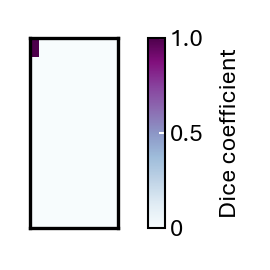

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(1,1), dpi=300, layout="tight")

data = np.zeros((10, 10))
data[0,0] = 1
data[0,1] = 0

ax.set_xticks([])
ax.set_yticks([])
cax = ax.imshow(data, cmap="BuPu", aspect="auto")
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="20%", pad=.1)
cbar = fig.colorbar(cax, cax=cbar_ax)
for s in cbar.ax.spines.values():
    s.set_linewidth(.5)
cbar.ax.set_yticks([0,.5,1])
cbar.ax.set_yticklabels([0,.5,1.], fontsize=6)
cbar.ax.tick_params(axis="both",width=.5,pad=1, length=1.4,direction='in', color='white')
cbar.ax.set_ylabel("Dice coefficient",fontsize=6)

fig.savefig(MAIN / "cbar.png")

In [44]:
import nibabel as nib

p_thr = .05

for f in ["0.125"]:

    #for sub_id in NORMAL_3T_SUB_IDS[1:]:
    for sub_id in ["003"]:

        #for pval_type in ["fdrp","uncp"]:
        for pval_type in ["uncp"]:

            all_masks = !ls /scratch/*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
            main_dscalar, = !ls /scratch/*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-ALL/GLM/*frequency-{f}_p_value.dscalar.nii
            run_dscalars = !ls /scratch/*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-??X??/GLM/*frequency-{f}_p_value.dscalar.nii

            # 1 - make mask
            mask = None
            n_masks = len(all_masks)
            for i in all_masks:
                _mask = (nib.load(i).get_fdata() > 0).astype(float)
                if mask is None:
                    mask = _mask
                else:
                    mask += _mask
            mask /= n_masks
            mask = (mask==1).astype(float)
            mask = mask[0,:VERTEX_TO]

            # 2 - main dscalar
            main_data = nib.load(main_dscalar).get_fdata()[0,:VERTEX_TO]
            main_data = (main_data < p_thr).astype(float) * mask

            png_out = REPRO_MAP / f"sub-{sub_id}_pval-{pval_type}_f-{f}_main.png"
            dscalar(
                png_out, main_data, 
                orientation="portrait", 
                hemisphere='right',
                palette="magma", 
                palette_params=PALETTE_PARAMS,
                transparent=False,
                flatmap=True,
                flatmap_style='plain',
            )

            # 3 - run-level dscalars
            run_data = None
            n_runs = len(run_dscalars)
            for i in run_dscalars:
                _run_data = nib.load(i).get_fdata()[0,:VERTEX_TO]
                _run_data = (_run_data < p_thr).astype(float) * mask
                if run_data is None:
                    run_data = _run_data
                else:
                    run_data += _run_data
            run_data /= n_runs

            png_out = REPRO_MAP / f"sub-{sub_id}_pval-{pval_type}_f-{f}_runlevel.png"
            dscalar(
                png_out, run_data, 
                orientation="portrait", 
                hemisphere='right',
                palette="magma", 
                palette_params=PALETTE_PARAMS,
                transparent=False,
                flatmap=True,
                flatmap_style='plain',
            )
            crop_and_save(png_out, str(png_out).replace("png", "cropped.png"), LEFT, TOP, RIGHT, BOTTOM)

            # 4 - overlap > .9
            overlap_data = (run_data >= .9).astype(float)
            
            png_out = REPRO_MAP / f"sub-{sub_id}_pval-{pval_type}_f-{f}_overlap_0.9.png"
            dscalar(
                png_out, overlap_data, 
                orientation="portrait", 
                hemisphere='right',
                palette="magma", 
                palette_params=PALETTE_PARAMS,
                transparent=False,
                flatmap=True,
                flatmap_style='plain',
            )
            
            # 5 - overlap > 1.
            overlap_data = (run_data >= 1.).astype(float)
            
            png_out = REPRO_MAP / f"sub-{sub_id}_pval-{pval_type}_f-{f}_overlap_1.0.png"
            dscalar(
                png_out, overlap_data, 
                orientation="portrait", 
                hemisphere='right',
                palette="magma", 
                palette_params=PALETTE_PARAMS,
                transparent=False,
                flatmap=True,
                flatmap_style='plain',
            )


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.072626 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.024973 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.038585 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.023072 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.070252 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.024633 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.038252 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.022667 seconds.


Info: Time to read /tmp/ImageDense.dscalar.nii was 0.040859

Cropped image saved successfully as /opt/app/notebooks/ComputeCanada/frequency_tagging/figures/im_mapping/run_level_reproducibility/sub-003_pval-uncp_f-0.125_runlevel.cropped.png



Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.066841 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.02488 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.038933 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.022729 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.064968 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.024875 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.038876 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.02267 seconds.


Info: Time to read /tmp/ImageDense.dscalar.nii was 0.040791 s

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression

def regress_out_frequency(timeseries, sampling_rate, frequency):

    # Number of samples in the timeseries
    n_samples = len(timeseries)
    
    # Create time vector based on the sampling rate
    t = np.arange(n_samples) / sampling_rate
    
    # Build the design matrix with sin and cos components of the target frequency
    X = np.column_stack([np.sin(2 * np.pi * frequency * t), np.cos(2 * np.pi * frequency * t)])
    
    # Perform linear regression to fit the sinusoidal components
    model = LinearRegression().fit(X, timeseries)
    
    # Predict the fitted sinusoidal signal
    sinusoid_fit = model.predict(X)
    
    # Subtract the fitted sinusoidal component from the original timeseries
    residuals = timeseries - sinusoid_fit
    
    return residuals

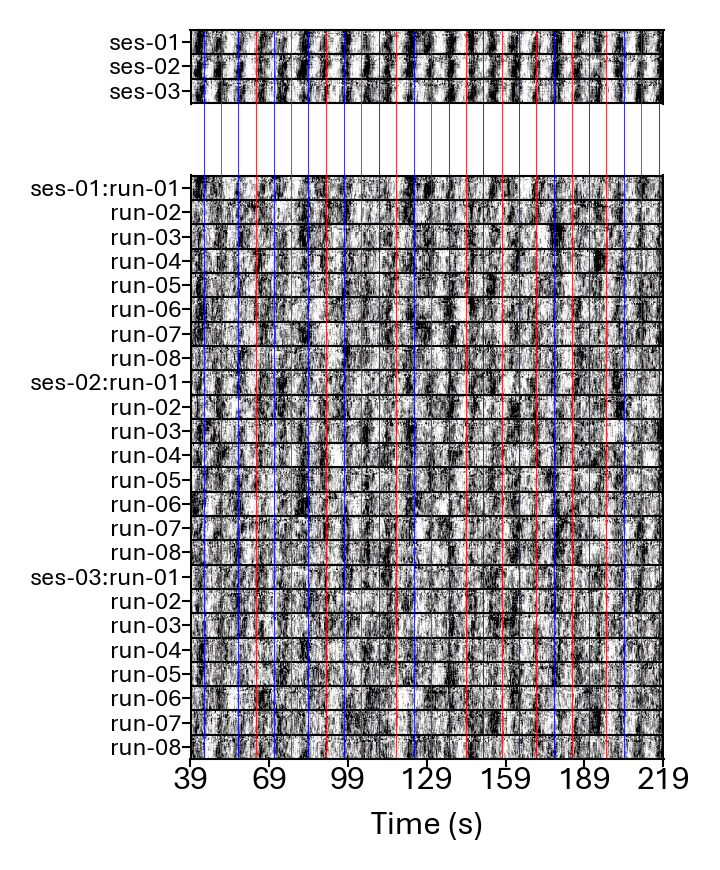

In [51]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

runfo=.5
TR = .3
bold_runs = !ls /scratch/copy
fig,ax = plt.subplots(figsize=(2.5,3), dpi=300, layout="tight")
concat_carpet_plot = None

bold_ses = {
    "01": None,
    "02": None,
    "03": None,
}

bold_ses_count = {
    "01": 0,
    "02": 0,
    "03": 0,
}

for bold_ix, bold_run in enumerate(bold_runs):
    ses_id = bold_run.split("ses-")[-1].split("_")[0]
    # Pick coord
    coords = np.where(run_data > runfo)[0]
    # Select 1 run
    bold_run = f"/scratch/copy/{bold_run}"
    # Load and filter data
    bold_data = nib.load(bold_run).get_fdata()[:,:VERTEX_TO]
    carpet_data = bold_data[:,coords]
    # Z-score normalize
    carpet_data = ( carpet_data - carpet_data.mean(0,keepdims=True) ) / carpet_data.std(0,keepdims=True)

    # Regress out other frequencies
    for i in range(carpet_data.shape[1]):
        #carpet_data[:,i] = regress_out_frequency(carpet_data[:,i], 1/TR, .125)
        carpet_data[:,i] = regress_out_frequency(carpet_data[:,i], 1/TR, .2)

    carpet_data = carpet_data.T
    if bold_ix == 0:
        concat_carpet_plot = carpet_data
    else:
        concat_carpet_plot = np.vstack((concat_carpet_plot, carpet_data))

    # save session average
    if bold_ses[ses_id] is None:
        bold_ses[ses_id] = carpet_data
    else:
        bold_ses[ses_id] += carpet_data
    bold_ses_count[ses_id] += 1

for ses_id in bold_ses.keys():
    bold_ses[ses_id] /= bold_ses_count[ses_id]
    bold_ses[ses_id] -= bold_ses[ses_id].mean(1,keepdims=True)
    bold_ses[ses_id] /= bold_ses[ses_id].std(1,keepdims=True)
concat_ses_carpet_plot = np.vstack( [i for i in bold_ses.values()] )


    
ax.imshow(np.vstack([concat_ses_carpet_plot,np.ones(concat_ses_carpet_plot.shape)*10,concat_carpet_plot]), vmin=-.8,vmax=.8,cmap="Greys_r",alpha=1., aspect="auto")

for s in ["top","bottom"]:
    ax.spines[s].set_visible(True)
    ax.spines[s].set_linewidth(.5)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xticks([i for i in range(700) if i%100==0])
ax.set_xticklabels([f"{(39+i*TR):.0f}" for i in range(700) if i%100==0], fontsize=8)
ax.set_yticks([i*(carpet_data.shape[0])+(carpet_data.shape[0]/2) for i in range(len(bold_runs)+6) if i not in [3,4,5]])
ax.set_yticklabels(
    ["ses-01","ses-02","ses-03"]+[f"ses-01:run-{str(i+1).zfill(2)}" if i==0 else f"run-{str(i+1).zfill(2)}" for i in range(8)]+[f"ses-02:run-{str(i+1).zfill(2)}" if i==0 else f"run-{str(i+1).zfill(2)}" for i in range(8)]+[f"ses-03:run-{str(i+1).zfill(2)}" if i==0 else f"run-{str(i+1).zfill(2)}" for i in range(8)],
    fontsize=8-2
)
ax.tick_params(axis="both", pad=0, width=.5, length=2)
ax.set_xlabel("Time (s)", fontsize=8)

for i in range(len(bold_runs)+6):
    if i in [4,5]:
        continue
    ax.plot([0,carpet_data.shape[1]-1],[i*carpet_data.shape[0]]*2,linewidth=.5,c='k')

ax.plot([-0.5]*2,[0,concat_ses_carpet_plot.shape[0]],linewidth=1.,c='k')
ax.plot([600.5]*2,[0,concat_ses_carpet_plot.shape[0]],linewidth=1.,c='k')
ax.plot([-0.5]*2,[concat_ses_carpet_plot.shape[0]*2,concat_ses_carpet_plot.shape[0]*2+concat_carpet_plot.shape[0]-1],linewidth=1.,c='k')
ax.plot([600.5]*2,[concat_ses_carpet_plot.shape[0]*2,concat_ses_carpet_plot.shape[0]*2+concat_carpet_plot.shape[0]-1],linewidth=1.,c='k')
for p in peaks:
    ax.axvline(x=p, c='r', linestyle='-',alpha=.8, linewidth=.25)
for p in troughs:
    ax.axvline(x=p, c='blue', linestyle='-',alpha=.8, linewidth=.25)
"""
period = 1/.125
for i in range(0, int(180/(period)+1)):
    ax.axvline([(period/TR)*i],c='k',linewidth=.4, alpha=.8, linestyle="dotted")
"""
#ax.set_title(f"{Path(bold_run).stem}",fontsize=8-2)

fig.savefig(MAIN / f"sub-{sub_id}_f-0.125_n-vertices-{carpet_data.shape[0]}_run-fo-{runfo}_stackedcarpetplot.png")


Compare carpet plot of run/session 1 to session 1

PearsonRResult(statistic=0.4128271906522637, pvalue=0.0)


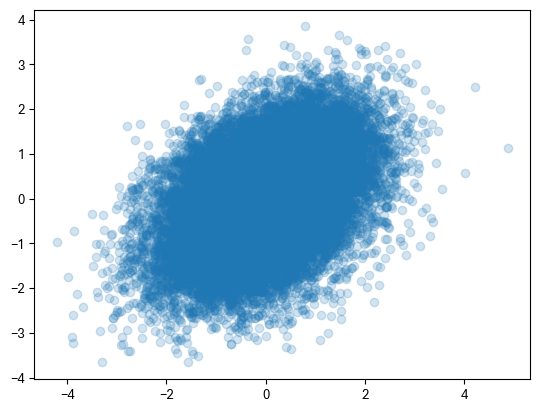

In [47]:
x = concat_carpet_plot[:44,:].flatten()
y = concat_ses_carpet_plot[:44,:].flatten()
from scipy.stats import pearsonr
print(pearsonr(x,y))
plt.scatter(x,y,alpha=.2)

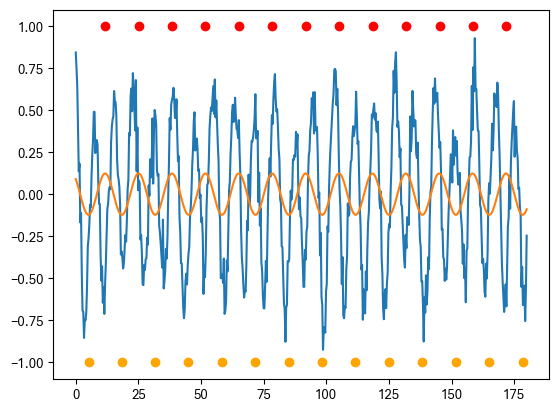

In [48]:
from scipy.signal import find_peaks
t= np.arange(0,601*.3,.3)
y = concat_ses_carpet_plot.mean(0)

target_frequency=.075
# Generate the sinusoidal regressors for the target frequency
cos_regressor = np.cos(2 * np.pi * target_frequency * t)
sin_regressor = np.sin(2 * np.pi * target_frequency * t)

# Stack regressors to create design matrix
X = np.column_stack((cos_regressor, sin_regressor))

# Fit the GLM model using Linear Regression
glm = LinearRegression()
glm.fit(X, y)
y_fit = glm.predict(X)

plt.plot(t, concat_ses_carpet_plot.mean(0))
plt.plot(t, y_fit)
peaks,_ = find_peaks(y_fit)
for p in peaks:
    plt.scatter(p*.3, 1,c='r')
troughs,_ = find_peaks(-1*y_fit)
for p in troughs:
    plt.scatter(p*.3, -1,c='orange')

In [49]:
y_fit

array([ 9.18160736e-02,  7.90602327e-02,  6.47663941e-02,  4.92197583e-02,
        3.27305224e-02,  1.56276908e-02, -1.74748900e-03, -1.90483355e-02,
       -3.59296504e-02, -5.20546062e-02, -6.71014666e-02, -8.07700065e-02,
       -9.27875017e-02, -1.02914171e-01, -1.10947960e-01, -1.16728573e-01,
       -1.20140672e-01, -1.21116176e-01, -1.19635620e-01, -1.15728547e-01,
       -1.09472912e-01, -1.00993533e-01, -9.04595952e-02, -7.80812796e-02,
       -6.41055666e-02, -4.88113094e-02, -3.25036693e-02, -1.55080275e-02,
        1.83650718e-03,  1.91838648e-02,  3.61879190e-02,  5.25093932e-02,
        6.78226303e-02,  8.18220899e-02,  9.42284454e-02,  1.04794157e-01,
        1.13308409e-01,  1.19601321e-01,  1.23547332e-01,  1.25067708e-01,
        1.24132113e-01,  1.20759216e-01,  1.15016314e-01,  1.07017995e-01,
        9.69238449e-02,  8.49352704e-02,  7.12914754e-02,  5.62646902e-02,
        4.01547397e-02,  2.32830604e-02,  5.98628775e-03, -1.13904612e-02,
       -2.85004738e-02, -

In [50]:
y_fit

array([ 9.18160736e-02,  7.90602327e-02,  6.47663941e-02,  4.92197583e-02,
        3.27305224e-02,  1.56276908e-02, -1.74748900e-03, -1.90483355e-02,
       -3.59296504e-02, -5.20546062e-02, -6.71014666e-02, -8.07700065e-02,
       -9.27875017e-02, -1.02914171e-01, -1.10947960e-01, -1.16728573e-01,
       -1.20140672e-01, -1.21116176e-01, -1.19635620e-01, -1.15728547e-01,
       -1.09472912e-01, -1.00993533e-01, -9.04595952e-02, -7.80812796e-02,
       -6.41055666e-02, -4.88113094e-02, -3.25036693e-02, -1.55080275e-02,
        1.83650718e-03,  1.91838648e-02,  3.61879190e-02,  5.25093932e-02,
        6.78226303e-02,  8.18220899e-02,  9.42284454e-02,  1.04794157e-01,
        1.13308409e-01,  1.19601321e-01,  1.23547332e-01,  1.25067708e-01,
        1.24132113e-01,  1.20759216e-01,  1.15016314e-01,  1.07017995e-01,
        9.69238449e-02,  8.49352704e-02,  7.12914754e-02,  5.62646902e-02,
        4.01547397e-02,  2.32830604e-02,  5.98628775e-03, -1.13904612e-02,
       -2.85004738e-02, -